# 왜 안 도ㅑㅐ

In [3]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Pretendard'
plt.rcParams['axes.unicode_minus'] = False

boston = pd.read_csv('./boston-housing.csv', header=None, sep=r'\s+')
boston.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'PRICE']
display(boston.head())  # print 말고 dataframe 제대로 보고싶으면 사용하는 법.
# print(boston.head())  # 얘는 못생김.

# 변수 설명 딕셔너리
feature_descriptions = {
    'CRIM': '지역별 1인당 범죄율',
    'ZN': '25,000 sq.ft. 이상 주거지역 비율',
    'INDUS': '비소매업 지역 비율', 
    'CHAS': '찰스강 인접 여부 (1: 인접, 0: 비인접)',
    'NOX': '일산화질소 농도 (ppm)',
    'RM': '주택당 평균 방 개수',
    'AGE': '1940년 이전 건축 주택 비율',
    'DIS': '보스턴 고용센터까지 가중거리',
    'RAD': '방사형 고속도로 접근성 지수',
    'TAX': '재산세율',
    'PTRATIO': '학생-교사 비율',
    'B': '흑인 거주 비율 관련 지수',
    'LSTAT': '하위계층 비율',
    'PRICE': '주택 중간값 (단위: $1000)'
}

for var, desc in feature_descriptions.items():
    print(f"  {var}: {desc}")

print(f"\n기본 정보:")
print(boston.info())

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


  CRIM: 지역별 1인당 범죄율
  ZN: 25,000 sq.ft. 이상 주거지역 비율
  INDUS: 비소매업 지역 비율
  CHAS: 찰스강 인접 여부 (1: 인접, 0: 비인접)
  NOX: 일산화질소 농도 (ppm)
  RM: 주택당 평균 방 개수
  AGE: 1940년 이전 건축 주택 비율
  DIS: 보스턴 고용센터까지 가중거리
  RAD: 방사형 고속도로 접근성 지수
  TAX: 재산세율
  PTRATIO: 학생-교사 비율
  B: 흑인 거주 비율 관련 지수
  LSTAT: 하위계층 비율
  PRICE: 주택 중간값 (단위: $1000)

기본 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13 

In [40]:
from fastapi.background import P


def get_data_profile(df: pd.DataFrame, target_col=None):
    """종합적인 데이터 프로파일링 함수"""
    print('=' * 50)
    print('종합 데이터 품질 리포트')
    print('=' * 50)

    # 1. 기본 통계
    print(f'\n1. 기본정보')
    print(f'- 데이터 크기: {df.shape[0]}행 x {df.shape[1]}열')
    print(f'- 메모리 사용량: {df.memory_usage(deep=True).sum()/1024**2:.2f}mb')
    print(f'- 수치형 변수: {len(df.select_dtypes(include=['number']).columns)}개')
    print(f'- 범주형 변수: {len(df.select_dtypes(include=['object']).columns)}개')

    # 2. 결측값 분석
    print(f'\n2. 결측값 분석')
    missing_info = df.isnull().sum()
    m_pct = (missing_info / len(df)) * 100
    if missing_info.sum() == 0:
        print('결측값 없음. 완전')
    else:
        missing_sum = pd.DataFrame({
            '결측수': missing_info,
            '결측율(%)': m_pct,
        }).round(2)
        missing_sum = missing_sum[missing_sum['결측수'] > 0]
        display(missing_sum)

    # 3. 데이터 타입별 분석
    print(f'\n3. 수치형 변수 품질 분석')
    num_cols = df.select_dtypes(include=['number']).columns

    quality_report = []
    for col in num_cols:
        col_data = df[col].dropna()
        # 기본 통계
        stats = {
            '변수명': col,
            '평균': col_data.mean(),
            '표준편차': col_data.std(),
            '최솟값': col_data.min(),
            '최댓값': col_data.max(),
            '왜도': col_data.skew(),
            '첨도': col_data.kurtosis(),
        }
        # 이상값 비율
        Q1 = col_data.quantile(0.25)
        Q3 = col_data.quantile(0.75)
        IQR = Q3 - Q1
        mask = (col_data < Q1 - 1.5 * IQR) | (col_data > Q3 + 1.5 * IQR)
        outliers = col_data[mask]
        stats['이상값비율(%)'] = (len(outliers) / len(col_data)) * 100

        # 유일값 비율
        stats['유일값비율(%)'] = (col_data.nunique() / len(col_data)) * 100
        quality_report.append(stats)
    quality_df = pd.DataFrame(quality_report).round(3)
    display(quality_df)

    # 4. 분포 이상 감지
    print(f'\n4. 분포 이상 감지')
    print(f'\n- 극심한 왜도(|skewness| > 2)')
    high_skews = quality_df[abs(quality_df['왜도']) > 2]['변수명'].to_list()

    if high_skews: # high_skews 리스트가 빈 리스트가 아니라면
        for var in high_skews:
            skew_val = quality_df[quality_df['변수명'] == var].iloc[0]['왜도']
            print(f'--{var}: 왜도 = {skew_val: 3f}')
    else:
        print('-- 정상 범위 내 분포')

    print('\n- 높은 이상값 비율(>5%)')
    high_outliers = quality_df[quality_df['이상값비율(%)'] > 5]['변수명'].tolist()
    
    print(high_outliers)
    if high_outliers: # high_skews 리스트가 빈 리스트가 아니라면
        for var in high_outliers:
            outliers_pct = quality_df[quality_df['변수명'] == var].iloc[0]['이상값비율(%)']
            print(f'--{var}: 이상값 = {outliers_pct:.1f}%')
    else:
        print('-- 이상값 비율 양호')

    return quality_df


get_data_profile(boston)
print('dkdk')

종합 데이터 품질 리포트

1. 기본정보
- 데이터 크기: 506행 x 14열
- 메모리 사용량: 0.05mb
- 수치형 변수: 14개
- 범주형 변수: 0개

2. 결측값 분석
결측값 없음. 완전

3. 수치형 변수 품질 분석


,변수명,평균,표준편차,최솟값,최댓값,왜도,첨도,이상값비율(%),유일값비율(%)
0,CRIM,3.614,8.602,0.006,88.976,5.223,37.131,13.043,99.605
1,ZN,11.364,23.322,0.000,100.000,2.226,4.032,13.439,5.138
2,INDUS,11.137,6.860,0.460,27.740,0.295,-1.234,0.000,15.020
3,CHAS,0.069,0.254,0.000,1.000,3.406,9.638,6.917,0.395
4,NOX,0.555,0.116,0.385,0.871,0.729,-0.065,0.000,16.008
5,RM,6.285,0.703,3.561,8.780,0.404,1.892,5.929,88.142
6,AGE,68.575,28.149,2.900,100.000,-0.599,-0.968,0.000,70.356
7,DIS,3.795,2.106,1.130,12.126,1.012,0.488,0.988,81.423
8,RAD,9.549,8.707,1.000,24.000,1.005,-0.867,0.000,1.779
9,TAX,408.237,168.537,187.000,711.000,0.670,-1.142,0.000,13.043



4. 분포 이상 감지

- 극심한 왜도(|skewness| > 2)
--CRIM: 왜도 =  5.223000
--ZN: 왜도 =  2.226000
--CHAS: 왜도 =  3.406000
--B: 왜도 = -2.890000

- 높은 이상값 비율(>5%)
['CRIM', 'ZN', 'CHAS', 'RM', 'B', 'PRICE']
--CRIM: 이상값 = 13.0%
--ZN: 이상값 = 13.4%
--CHAS: 이상값 = 6.9%
--RM: 이상값 = 5.9%
--B: 이상값 = 15.2%
--PRICE: 이상값 = 7.9%
dkdk


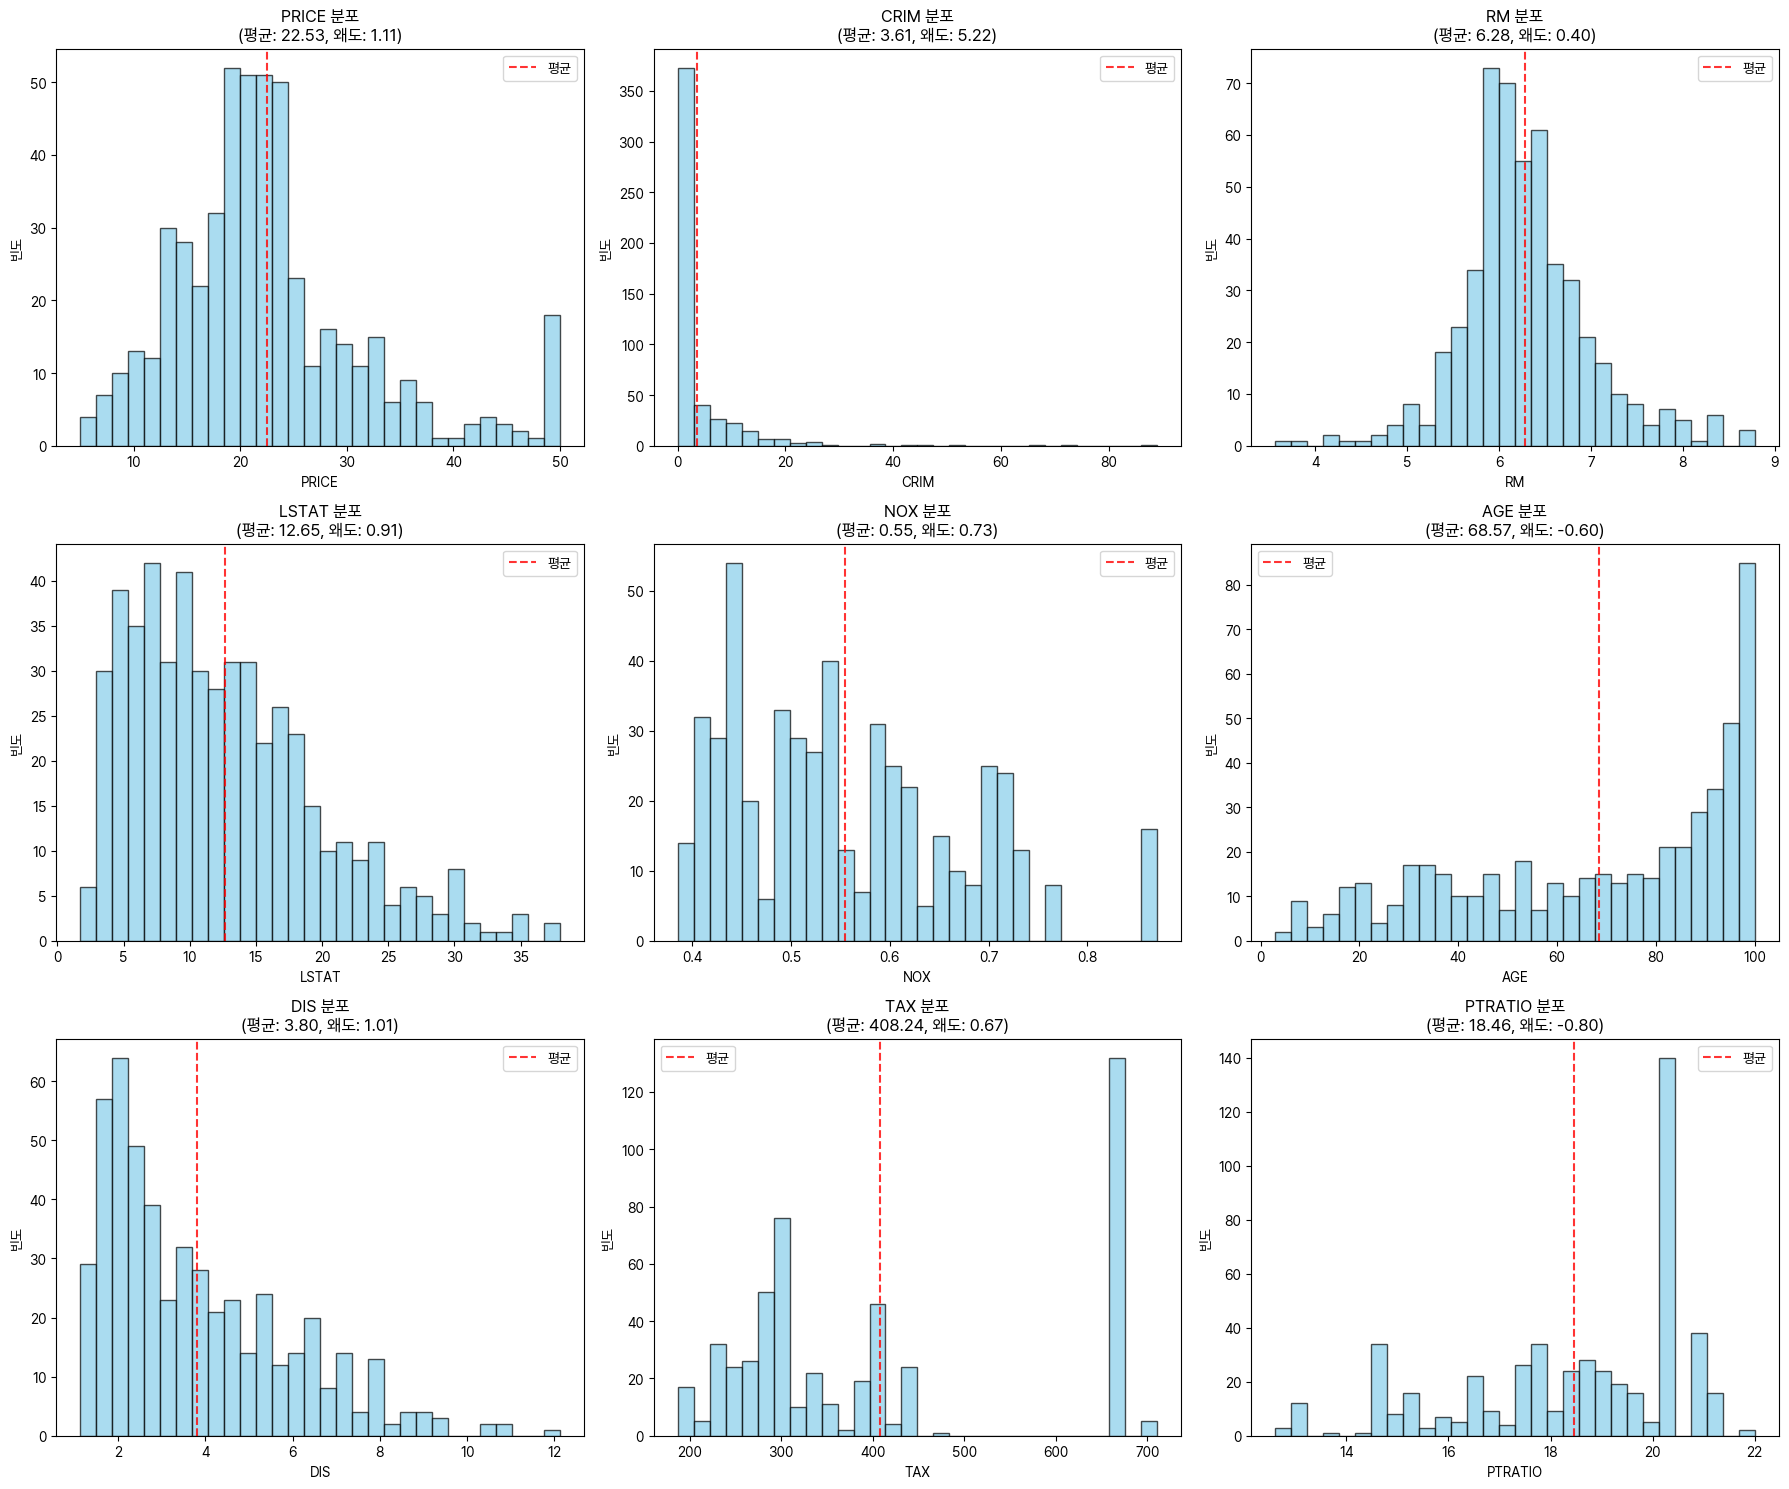

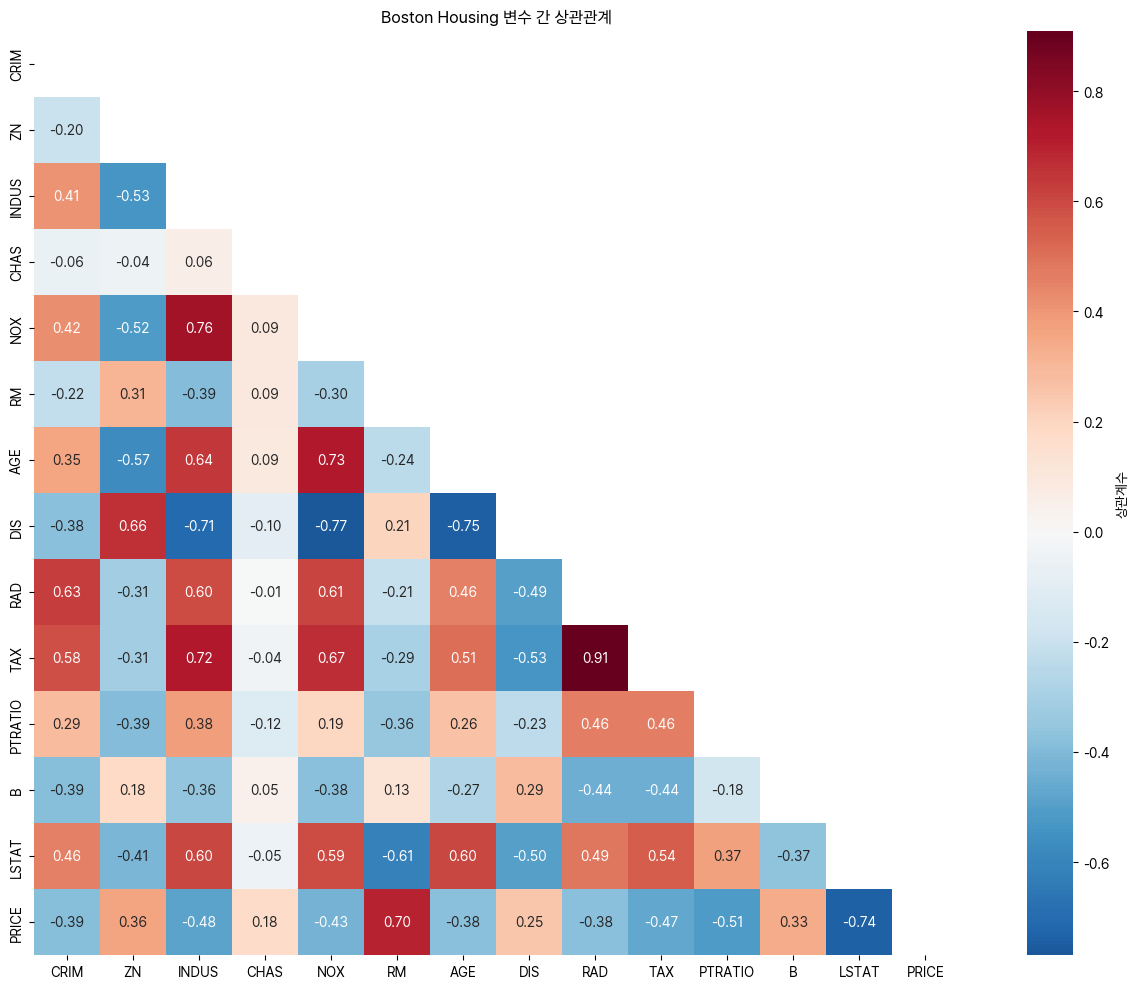

=== 상관관계 분석 결과 ===
PRICE와 상관관계가 높은 변수들:
  LSTAT: 0.738 (음의 상관관계)
  RM: 0.695 (양의 상관관계)
  PTRATIO: 0.508 (음의 상관관계)


In [42]:
# 3단계: 시각적 품질 진단
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.ravel()

# 주요 변수들의 분포 시각화
key_vars = ['PRICE', 'CRIM', 'RM', 'LSTAT', 'NOX', 'AGE', 'DIS', 'TAX', 'PTRATIO']

for i, var in enumerate(key_vars):
    if i < len(axes):
        # 히스토그램과 박스플롯 조합
        ax = axes[i]
        
        # 히스토그램
        ax.hist(boston[var], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        ax.set_title(f'{var} 분포\n(평균: {boston[var].mean():.2f}, 왜도: {boston[var].skew():.2f})')
        ax.set_xlabel(var)
        ax.set_ylabel('빈도')
        
        # 평균선 표시
        ax.axvline(boston[var].mean(), color='red', linestyle='--', alpha=0.8, label='평균')
        ax.legend()

plt.tight_layout()
plt.show()

# 상관관계 히트맵으로 품질 검증
plt.figure(figsize=(14, 10))
correlation_matrix = boston.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', 
            center=0, cmap='RdBu_r', square=True, cbar_kws={'label': '상관계수'})
plt.title('Boston Housing 변수 간 상관관계')
plt.tight_layout()
plt.show()

print("=== 상관관계 분석 결과 ===")
price_corr = correlation_matrix['PRICE'].abs().sort_values(ascending=False)
print("PRICE와 상관관계가 높은 변수들:")
for var, corr in price_corr.items():
    if var != 'PRICE' and corr > 0.5:
        print(f"  {var}: {corr:.3f} ({'양의 상관관계' if correlation_matrix['PRICE'][var] > 0 else '음의 상관관계'})")

In [ ]:
# 5단계: 변수 간 논리적 일관성 검증